# Imports and the written functions 

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
# pyarxaas API
from pyarxaas import ARXaaS, Dataset
from pyarxaas.privacy_models import KAnonymity, LDiversityDistinct,LDiversityShannonEntropy
from pyarxaas import AttributeType
import logging
logging.basicConfig(level=logging.INFO)
arxaas = ARXaaS('http://localhost:8080')

INFO:pyarxaas.arxaas_connector:Connected to url=http://localhost:8080 status=200


In [5]:
# This cell includes all necessary functions for Encryption and Decryption of the "id" of dataset using 
# multi-dimensional Cellular Automata
def Chaotic(KeyNumber,privacy):
    int_key=0
    first=False
    while int_key==0:
        if first==False:
            for i in range(privacy):
                    KeyNumber=4*KeyNumber*(1-KeyNumber)
                    first=True
        else:
            KeyNumber=4*KeyNumber*(1-KeyNumber)
        KeyNumberp=KeyNumber*10**4  
        key=bin(round(KeyNumberp))[2:10]
        int_key=int(key,2)
        privacy=privacy+1
    return key

def CA(Rull, initial, nrpt):
    
    # This function construct 1d Cellular Automata 
    RullSet=bin(round(Rull))[2:10]
    RullSet=[i for i in RullSet]
    for i in range(8-len(RullSet)):
        RullSet=['0']+RullSet
    #print(RullSet)

    rulls={}
    for i in range (8):
        rulls[i]=RullSet[-i-1]
        #print(i,RullSet[-i-1])
    #print(rulls) 
    Cells=[]
    #print(initial)
    
    Cells.append(''.join(initial))
    Int_Cells=[int(''.join(initial),2)]
    y=len(initial)
    binary_list=[]
    for j in range(nrpt):
        RowCells=[]
        for i in range(y):
            if i==0:
                cpre=Cells[j][y-1]
                c=Cells[j][i]
                cnext=Cells[j][i+1]
            if i==y:
                cpre=Cells[j][i-1]
                c=Cells[j][i]
                cnext=Cells[j][0]
            if i>0 and i<y-1:
                cpre=Cells[j][i-1]
                c=Cells[j][i]
                cnext=Cells[j][i+1]
            bins=''.join([str(cpre),str(c),str(cnext)])
            RowCells.append(rulls[int(bins,2)])
            #print((cpre,c,cnext), int(bins,2), rulls[int(bins,2)])
        binaryCells=''.join(RowCells)
        binary_list.append(RowCells)
        Cells.append(binaryCells) 
    
        
        Int_Cells.append(int(binaryCells,2))
        #print(Int_Cells)
    key=[i for i in initial]
    binary_list=[key]+binary_list
    return (Int_Cells,binary_list)

def batch_encrypt(namelist,Rull,FloatKey,Privacy):
    encrypt=False
    mx=max([len(i) for i in namelist])
    rowNo=len(namelist)
    for idx in range(len(namelist)):
        name=namelist[idx]
        if len(name)<mx:
            encrypt=True
            for i in range(mx-len(name)):
                namelist[idx]=chr(random.randrange(123, 254, 3))+namelist[idx]
            
    ls=mx
    chars=[]
    crkey=[]
    for ch in namelist[0]:
        #ts=binary(char)
        ts=ord(ch)
        chars.append(ts)
        
    #print(chars)
    key=Chaotic(FloatKey,Privacy)
    
    #print(key)
    key_list=[i for i in key]
    
    
    for i in range(8-len(key_list)):
        key_list=['0']+key_list
    #print(key_list)
    Cells,Binary=CA(Rull, key, ls-1)

    Rows=[]
    for c in Binary:
        #print(c)
        CellRows,_=CA(Rull, c, rowNo-1)
        Rows.append(CellRows)
    #print(Rows)
    
    for idx in range(len(namelist)):
        name=namelist[idx]
        chars=[]
        for ch in name:
            #ts=binary(char)
            ts=ord(ch)
            chars.append(ts)
            
        for i in range(len(chars)):
            #print(Rows[i][idx])
            #print(chars[i]^Rows[i][idx])
            chars[i]=chr(chars[i]^Rows[i][idx])
        if encrypt==False:
            newname=[]
            for ch in chars:
                if ord(ch)<123:
                    newname.append(ch)
        else:
            newname=chars
        encrypted=''.join(newname)
        namelist[idx]=encrypted
    return namelist

In [6]:
# Rntropy function
def entropy(df_new,df,quasiidentifiers,identifier):
    #df_new= dataset after anonymization
    #df=dataset before anonymization
    #quasiidentifiers= a list of quasiidentifying attributes
    #identifier= an arbitrary identifying attribute
    print('quasiidentifiers:')
    print(quasiidentifiers)
    res=df_new.groupby(by=quasiidentifiers).count()[identifier]
    hd2=0
    n2=len(df_new)
    for ci in res:
        portion=ci/n2
        hd2+=(portion)*np.log10(portion)
    hd2=-hd2
    
    res=df.groupby(by=quasiidentifiers).count()[identifier]
    hd=0
    n=len(df)
    for ci in res:
        portion=ci/n
        hd+=(portion)*np.log10(portion)
    hd=-hd
    
    print('Entropy for unanonymous dataset: ' + str(hd))
    print('Entropy for anonymous dataset: ' + str(hd2))
    print('Loss of information: ' + str(hd-hd2))
    print('Normalized loss of information: ' + str((hd-hd2)/np.log10(n)))
    return hd2,hd-hd2,(hd-hd2)/np.log10(n)

# Reading Data and Preprocessing

In [7]:
df=pd.read_csv('dataset - Privacy-Engineering.csv')
df.head()

,id,gender,dob,zipcode,education,employment,children,marital_status,ancestry,number_vehicles,commute_time,accommodation,disease
0,Amelia Morrow,female,12/1950,26904,High School,Retired,2,married,Africa,2,0.0,Own house,Alzheimer's disease
1,Lillian Cole,female,4/1940,78088,PhD/md,Retired,1,married,Africa,1,0.0,Rent flat,multiple sclerosis
2,Lillian Simpson,female,12/1966,51502,Bachelor,Employed,1,married,Asia,0,0.1,Rent flat,heart disease
3,Avery Richards,female,4/1943,54080,Bachelor,Retired,1,married,Africa,0,0.0,Rent room,endometriosis
4,Sophia Alvarado,female,10/1947,68785,High School,Retired,1,married,Europe,0,0.0,Rent flat,gastritis


## Preprocessing

In [8]:
for i in range(len(df)):
    df.iloc[i,3]=str(df.iloc[i,3])

In [9]:
for i in range(len(df)):
    dateTemp=df.iloc[i,2].split('/')
    df.iloc[i,2]=dateTemp[1]+'-'+dateTemp[0]

#### Checking ids (names)

In [10]:
b=df.groupby(by='id').count()['gender']>1
repeated_name=sum(list(df.groupby(by='id').count()['gender'][b.to_frame()['gender']==np.bool_(True)]))

print('There are ' + str(len(df)) + ' records.')
print(str(repeated_name) + ' names are repeated names (id).')
repeated=b[b.to_frame()['gender']==np.bool_(True)].to_frame()
repeated_name=len(repeated)
print('The number of repeated (ids) names is '+str(repeated_name))
 
print(repeated)

There are 2000 records.
55 names are repeated names (id).
The number of repeated (ids) names is 27
                  gender
id                      
Adrian Roberts      True
Alex Price          True
Amelia Smith        True
Andrew Carpenter    True
Daniel Sanchez      True
Eliana Johnson      True
Elijah Davis        True
Ella Hernandez      True
Emma Smith          True
Evan Holmes         True
Evelyn Williams     True
Ezra Hunt           True
Gavin Wilson        True
Isabella Johnson    True
James Johnson       True
Joshua Williams     True
Kevin Thomas        True
Landon Smith        True
Mia Cook            True
Noah White          True
Noah Wilson         True
Olivia Watson       True
Samuel Garcia       True
Theodore Smith      True
Wyatt Gray          True
Zachary Smith       True
Zoey Weber          True


In [11]:
length_name_list=[]
name_list=df['id'].to_list()
for i in range(len(df)):
    length_name_list.append(len(name_list[i]))
df['id_length']=length_name_list

Text(0.5, 1.0, 'The distribution of the length of ids (names)')

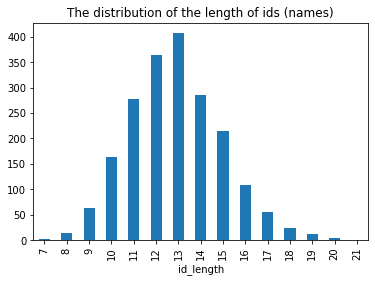

In [12]:
df.groupby(by='id_length').count()['gender'].plot(kind='bar')
plt.title('The distribution of the length of ids (names)')

In [13]:
del(df['id_length'])

#### Checking ancestry 

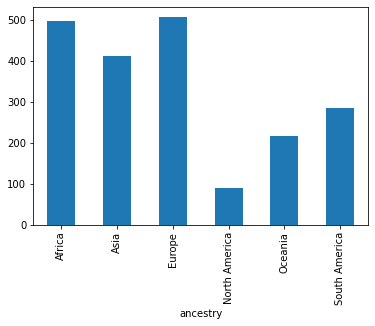

In [14]:
df.groupby(by='ancestry').count()['gender'].plot(kind='bar')



#### Checking education 

Text(0.5, 1.0, 'The distribution of the education types')

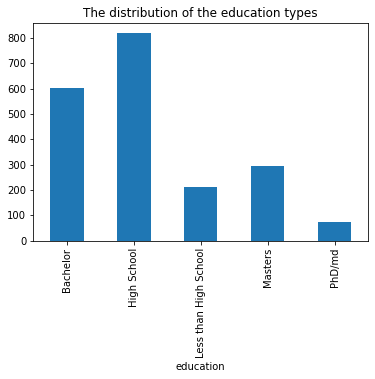

In [15]:
df.groupby(by='education').count()['gender'].plot(kind='bar')
plt.title('The distribution of the education types')

In [16]:
#### Checking diseases

Text(0.5, 1.0, 'The distribution of the disease types')

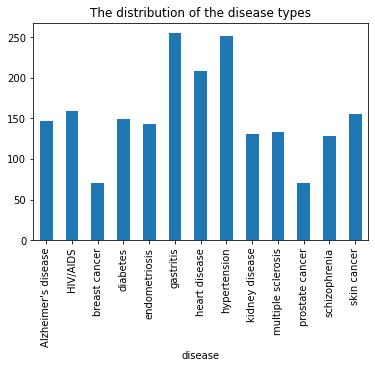

In [17]:
df.groupby(by=['disease']).count()['dob'].plot(kind='bar')
plt.title('The distribution of the disease types')

## Zipcode Study

Text(0.5, 1.0, 'The distribution of the zipcodes')

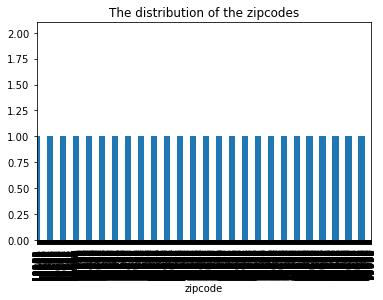

In [18]:
df.groupby(by=['zipcode']).count()['dob'].plot(kind='bar')
plt.title('The distribution of the zipcodes')

In [19]:
zip=f['zip_code']
zip=zip.astype(int)
zip=zip.astype(str)
for i in zip:
    myzip = zipcode.isequal(i)
    if myzip:
        print(myzip.state)

NameError: name 'f' is not defined

In [ ]:
import zipcodes
from pprint import pprint

In [ ]:
pprint(zipcodes.matching('77429-1145'))

In [2118]:
a=zipcodes.matching('54080')

In [2119]:
pprint(a)

[]


### What kind of zipcode is that?

## Applying the CA encryption to ids

In [85]:
# Chosen CA rule is 30 because it follows a chaotic behavior 
# key is chosen as 0.8413446 to ensure that the initial state of CA contains enough 1s 
# privacy could be any arbitrary number. Here, it is selected as 100
df['id']=batch_encrypt(list(df['id']),30,0.8413446,100)

#### Checking ids (names) after encryption

In [86]:
b=df.groupby(by='id').count()['gender']>1
repeated_name=sum(list(df.groupby(by='id').count()['gender'][b.to_frame()['gender']==np.bool_(True)]))

print('There are ' + str(len(df)) + ' records.')
print(str(repeated_name) + ' names are repeated names (id).')
repeated=b[b.to_frame()['gender']==np.bool_(True)].to_frame()
repeated_name=len(repeated)
print('The number of repeated (ids) names is '+str(repeated_name))
 
print(repeated)

There are 2000 records.
17 names are repeated names (id).
The number of repeated (ids) names is 3
                        gender
id                            
 È#Ì_û|âÂ8bél¶jõ-gæ     True
 Í Ê"wó$t§aâ>p     True
¾ ÆFÅ\rwâ m§uæ>l    True


As you can see, the number of the repeated ids (names) became 3, which are repeated 12 times while in the original data set, 27 ids are repeated 55 times together. Indeed, we are trying to cheat the adversary This number (3) may change at each running. You can get the true ids back using the same function, CA rule, key, and privacy.   

In [88]:
length_name_list=[]
name_list=df['id'].to_list()
for i in range(len(df)):
    length_name_list.append(len(name_list[i]))
df['id_length']=length_name_list

Text(0.5, 1.0, 'The distribution of the length of ids (names) after encryption.')

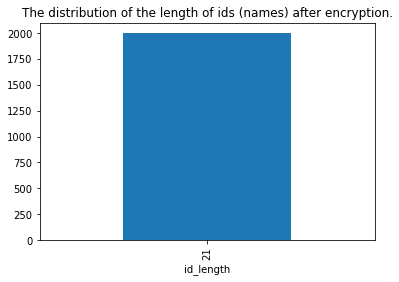

In [90]:
df.groupby(by='id_length').count()['gender'].plot(kind='bar')
plt.title('The distribution of the length of ids (names) after encryption.')

In [104]:
del(df['id_length'])

### Getting ids back using the same function

In [92]:
encrypted=df.copy()
encrypted['id']=batch_encrypt(list(encrypted['id']),30,0.8413446,100)

In [94]:
b=encrypted.groupby(by='id').count()['gender']>1
repeated_name=sum(list(encrypted.groupby(by='id').count()['gender'][b.to_frame()['gender']==np.bool_(True)]))

print('There are ' + str(len(df)) + ' records.')
print(str(repeated_name) + ' names are repeated names (id).')
repeated=b[b.to_frame()['gender']==np.bool_(True)].to_frame()
repeated_name=len(repeated)
print('The number of repeated (ids) names is '+str(repeated_name))
 
print(repeated)

There are 2000 records.
55 names are repeated names (id).
The number of repeated (ids) names is 27
                  gender
id                      
Adrian Roberts      True
Alex Price          True
Amelia Smith        True
Andrew Carpenter    True
Daniel Sanchez      True
Eliana Johnson      True
Elijah Davis        True
Ella Hernandez      True
Emma Smith          True
Evan Holmes         True
Evelyn Williams     True
Ezra Hunt           True
Gavin Wilson        True
Isabella Johnson    True
James Johnson       True
Joshua Williams     True
Kevin Thomas        True
Landon Smith        True
Mia Cook            True
Noah White          True
Noah Wilson         True
Olivia Watson       True
Samuel Garcia       True
Theodore Smith      True
Wyatt Gray          True
Zachary Smith       True
Zoey Weber          True


In [101]:
length_name_list=[]
name_list=encrypted['id'].to_list()
for i in range(len(encrypted)):
    length_name_list.append(len(name_list[i]))
encrypted['id_length']=length_name_list

Text(0.5, 1.0, 'The distribution of the length of ids (names) after decryption.')

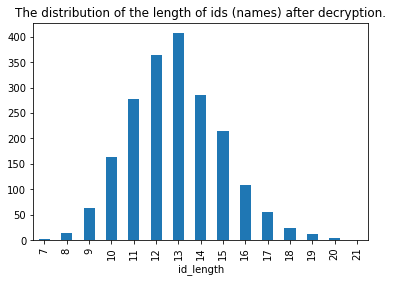

In [102]:
encrypted.groupby(by='id_length').count()['gender'].plot(kind='bar')
plt.title('The distribution of the length of ids (names) after decryption.')

In [ ]:
df=encrypted

In [103]:
del(encrypted)

## Pyarxx Hierarchy Creating: Creating Hierarchy for Zipcode, dob, and commute_time

Note that some hierarchies were built manually.

In [394]:
# zipcode hierarchy
zips=set(list(df['zipcode']))
zip_hierarchy=[]
for i in zips:
    local_zip=[]
    for j in range(len(i)-1, 0, -1):

        newzip=i[:j]
        for star in range(len(i)-len(newzip)):
            newzip=newzip+'*'
        #print(newzip)
        local_zip.append(newzip)
        
    local_zip.append(''.join(['*' for i in range(5)]))
    local_zip=[i]+local_zip
    zip_hierarchy.append(local_zip)
    
file_out=open('data/data_zipcode_hierarchy.csv',mode='w')
for line in zip_hierarchy:
    file_out.write(','.join(line)+'\n')
file_out.close()

In [395]:
# dob hierarchy
dob=set(list(df['dob']))
file_out=open('data/data_dob.csv',mode='w')  
for i in dob:
    decade=i.split('-')[0][0:-1]+'0s'
    file_out.write(','.join([i,i.split('-')[0],decade])+'\n')
file_out.close()

In [396]:
from pyarxaas.hierarchy import IntervalHierarchyBuilder
a=np.percentile(list( set(list(df['commute_time']))),q=33.3)
b=np.percentile(list( set(list(df['commute_time']))),q=66.6)
c=np.percentile(list( set(list(df['commute_time']))),q=90)
d=np.percentile(list( set(list(df['commute_time']))),q=100)
interval_based = IntervalHierarchyBuilder()
ages = list(df['commute_time'])
interval_based.add_interval(0,a, "low")
interval_based.add_interval(a,b, "intermediate")
interval_based.add_interval(b,c, "high")
interval_based.add_interval(c,4, "very high")
interval_based.level(0)\
    .add_group(2, "low")\
    .add_group(2, "high")
commute_hierarchy = arxaas.hierarchy(interval_based, list(df['commute_time']))

In [397]:
commute_hierarchy

[['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.1', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.1', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['2.1', 'intermediate', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.43', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['1.43', 'intermediate', 'low', '*'],
 ['0.77', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['3.43', 'very high', 'high', '*'],
 ['0.77', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.43', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.43', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 ['1.77', 'intermediate', 'low', '*'],
 ['0.0', 'low', 'low', '*'],
 

In [398]:
# gender hierarchy
gender_hierarchy=[['female', 'female'],['male', 'male']]

# Privacy Models 
We applied two strategies for privacy engineering: one dataset for both purposes, and two independent datasets.
We worked on the first strategy only just to do experiments. Our main approach is to provide two datasets.

## First Strategy: One dataset for both purposes

In [1079]:
dataset = Dataset.from_pandas(df)
dataset.describe()

data:
  headers:
    ['id', 'gender', 'dob', 'zipcode', 'education', 'employment', 'children', 'marital_status', 'ancestry', 'number_vehicles', 'commute_time', 'accommodation', 'disease']
rows:
    ['Amelia Morrow', 'female', '1950-12', '26904', '...', 2, 0.0, 'Own house', "Alzheimer's disease"]
    ['Lillian Cole', 'female', '1940-4', '78088', '...', 1, 0.0, 'Rent flat', 'multiple sclerosis']
    ['Lillian Simpson', 'female', '1966-12', '51502', '...', 0, 0.1, 'Rent flat', 'heart disease']
    ['Avery Richards', 'female', '1943-4', '54080', '...', 0, 0.0, 'Rent room', 'endometriosis']
    ['Sophia Alvarado', 'female', '1947-10', '68785', '...', 0, 0.0, 'Rent flat', 'gastritis']
    ...
attributes:
  field_name=id, type=QUASIIDENTIFYING, hierarchy=None
  field_name=gender, type=QUASIIDENTIFYING, hierarchy=None
  field_name=dob, type=QUASIIDENTIFYING, hierarchy=None
  field_name=zipcode, type=QUASIIDENTIFYING, hierarchy=None
  field_name=education, type=QUASIIDENTIFYING, hierarchy=None


In [1080]:
# unique table
dataset.set_attribute_type(AttributeType.INSENSITIVE, 'id')
dataset.set_attribute_type(AttributeType.INSENSITIVE, 'gender')# MODIFIED
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'dob')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'zipcode')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'education')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'employment')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'children')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'marital_status')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'ancestry')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'number_vehicles')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'commute_time')
dataset.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'accommodation')
dataset.set_attribute_type(AttributeType.SENSITIVE, 'disease')

In [1081]:
zipcode_hierarchy = pd.read_csv("data/data_zipcode_hierarchy.csv", sep=",", header=None)
dob = pd.read_csv("data/data_dob.csv", sep=",", header=None)
children_hierarchy = pd.read_csv("data/children_generalized.csv", sep=",")
employment_hierarchy = pd.read_csv("data/employment_generalized.csv", sep=",")
ancestry_hierarchy = pd.read_csv("data/ancestry_generalized.csv", sep=",")
accommodation_hierarchy = pd.read_csv("data/accommodation_generalized.csv", sep=",")
marital_status = pd.read_csv("data/marital_status_generalized.csv", sep=",")
education = pd.read_csv("data/education_generalized.csv", sep=",")
number_vehicles = pd.read_csv("data/vehicles_generalized.csv", sep=",")

In [1082]:
children_hierarchy.head()

,0,1,2,3,4
0,0,[0-1],[0-1],No,*
1,1,[1-2],[1-4],Yes,*
2,2,[2-4],[1-4],Yes,*
3,3,[2-4],[1-4],Yes,*
4,4,[4-6],[4-9],Yes,*


In [1083]:
employment_hierarchy.head()

,0,1,2
0,Retired,Not working,*
1,Employed,Working,*
2,Unemployed,Not Working,*
3,Student,Not Working,*


In [1084]:
ancestry_hierarchy.head()

,0,1
0,Africa,*
1,Asia,*
2,Europe,*
3,Oceania,*
4,South America,*


In [1085]:
zipcode_hierarchy.head()

,0,1,2,3,4,5
0,54284,5428*,542**,54***,5****,*****
1,25183,2518*,251**,25***,2****,*****
2,56078,5607*,560**,56***,5****,*****
3,95427,9542*,954**,95***,9****,*****
4,86792,8679*,867**,86***,8****,*****


In [1086]:
accommodation_hierarchy.head()

,0,1,2
0,Own house,owner,*
1,Rent flat,rental,*
2,Rent room,rental,*
3,Own flat,owner,*
4,Rent house,rental,*


In [1087]:
marital_status.head()

,0,1,2,3
0,married,wedded,coupled,*
1,divorced,once married,alone,*
2,widowed,once married,alone,*
3,single,bachelor,alone,*


In [1088]:
education.head()

,0,1,2
0,High School,Highschool diploma,Secondary or Elementary Ed.
1,PhD/md,Graduate Degree,Postsecondary Ed.
2,Bachelor,Ungraduate Degree,Postsecondary Ed.
3,Masters,Graduate Degree,Postsecondary Ed.
4,Less than High School,Elementary Ed.,Secondary or Elementary Ed.


In [1089]:
number_vehicles.head()

,0,1,2,3
0,0,[0-1[,No,*
1,1,[1-2[,Yes,*
2,2,[2-4[,Yes,*
3,3,[2-4[,Yes,*


In [1090]:
dob.head()

,0,1,2
0,1954-2,1954,1950s
1,2001-1,2001,2000s
2,1968-2,1968,1960s
3,1988-9,1988,1980s
4,1960-1,1960,1960s


In [1091]:
dataset.set_hierarchy("children", children_hierarchy)
dataset.set_hierarchy("employment", employment_hierarchy)
dataset.set_hierarchy("ancestry", ancestry_hierarchy)
dataset.set_hierarchy("commute_time", commute_hierarchy)
dataset.set_hierarchy("zipcode", zipcode_hierarchy)
dataset.set_hierarchy("accommodation", accommodation_hierarchy)
dataset.set_hierarchy("marital_status", marital_status)
dataset.set_hierarchy("education", education)
dataset.set_hierarchy("number_vehicles", number_vehicles)
dataset.set_hierarchy("dob", dob)

In [1092]:
risk_profile = arxaas.risk_profile(dataset)

In [1093]:
risk_profile.re_identification_risk

{'estimated_journalist_risk': 1.0,
 'records_affected_by_highest_prosecutor_risk': 1.0,
 'sample_uniques': 1.0,
 'lowest_risk': 1.0,
 'estimated_prosecutor_risk': 1.0,
 'highest_journalist_risk': 1.0,
 'records_affected_by_lowest_risk': 1.0,
 'average_prosecutor_risk': 1.0,
 'estimated_marketer_risk': 1.0,
 'highest_prosecutor_risk': 1.0,
 'records_affected_by_highest_journalist_risk': 1.0,
 'population_uniques': 1.0}

In [1094]:
risk_profile.distribution_of_risk_dataframe().head()

,interval,recordsWithRiskWithinInterval,recordsWithMaximalRiskWithinInterval
0,"[50,100]",1.0,1.0
1,"[33.4,50)",0.0,0.0
2,"[25,33.4)",0.0,0.0
3,"[20,25)",0.0,0.0
4,"[16.7,20)",0.0,0.0


### Anonymization (2-anonymity, 2-diversity)

In [1095]:
ldivesModel=LDiversityDistinct(2,'disease')

In [1096]:
kanon = KAnonymity(2)

In [1098]:
anon_result = arxaas.anonymize(dataset, [kanon,ldivesModel],suppression_limit=.2)

In [1099]:
unique_dataset=anon_result.dataset.to_dataframe()

In [1100]:
unique_dataset.head()

,id,gender,dob,zipcode,education,employment,children,marital_status,ancestry,number_vehicles,commute_time,accommodation,disease
0,Amelia Morrow,female,1950s,*****,Highschool diploma,Not working,[1-4],coupled,*,2,*,owner,Alzheimer's disease
1,Lillian Cole,female,*,*,*,*,*,*,*,*,*,*,multiple sclerosis
2,Lillian Simpson,female,1960s,*****,Ungraduate Degree,Working,[1-4],coupled,*,0,*,rental,heart disease
3,Avery Richards,female,1940s,*****,Ungraduate Degree,Not working,[1-4],coupled,*,0,*,rental,endometriosis
4,Sophia Alvarado,female,1940s,*****,Highschool diploma,Not working,[1-4],coupled,*,0,*,rental,gastritis


In [1101]:
print('Is dataset anonymous? ' + anon_result.anonymization_status)

Is dataset anonymous? ANONYMOUS


In [1102]:
anon_rp = anon_result.risk_profile

In [1104]:
anon_rp.re_identification_risk

{'estimated_journalist_risk': 0.5,
 'records_affected_by_highest_prosecutor_risk': 0.09111880046136102,
 'sample_uniques': 0.0,
 'lowest_risk': 0.04,
 'estimated_prosecutor_risk': 0.5,
 'highest_journalist_risk': 0.5,
 'records_affected_by_lowest_risk': 0.02883506343713956,
 'average_prosecutor_risk': 0.17762399077277968,
 'estimated_marketer_risk': 0.17762399077277968,
 'highest_prosecutor_risk': 0.5,
 'records_affected_by_highest_journalist_risk': 0.09111880046136102,
 'population_uniques': 0.0}

In [1105]:
anon_rp.distribution_of_risk_dataframe().head(10)

,interval,recordsWithRiskWithinInterval,recordsWithMaximalRiskWithinInterval
0,"[50,100]",0.000000,1.000000
1,"[33.4,50)",0.091119,1.000000
2,"[25,33.4)",0.112457,0.908881
3,"[20,25)",0.099193,0.796424
4,"[16.7,20)",0.069204,0.697232
5,"[14.3,16.7)",0.055363,0.628028
6,"[12.5,14.3)",0.040369,0.572664
7,"[10,12.5)",0.104383,0.532295
8,"[9,10)",0.061130,0.427912
9,"[8,9)",0.027682,0.366782


#### Entropy 

In [1106]:
anon_rp.quasi_identifiers
res_en=entropy(unique_dataset,df,anon_rp.quasi_identifiers,'id')

quasiidentifiers:
['zipcode', 'marital_status', 'education', 'ancestry', 'children', 'dob', 'accommodation', 'commute_time', 'employment', 'number_vehicles']
Entropy for unanonymous dataset: 3.301029995664109
Entropy for anonymous dataset: 2.221139870323038
Loss of information: 1.079890125341071
Normalized loss of information: 0.32713732585270194


## Second Strategy: Two independent dataset

### Impact of stress

In [987]:
df_stress=df.copy()
del(df_stress['ancestry'])
del(df_stress['number_vehicles'])
#del(df_stress['education'])

In [988]:
dataset_stress = Dataset.from_pandas(df_stress)

In [989]:
# unique table
dataset_stress.set_attribute_type(AttributeType.INSENSITIVE, 'id')
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'gender') 
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'dob') # add DECADE 
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'zipcode') #  2-LEVEL
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'education') #  3-LEVEL
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'employment') # 1-LEVEL
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'children') # 2-lEVEL
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'marital_status') # 2-level
#dataset_stress.set_attribute_type(AttributeType.INSENSITIVE, 'ancestry') # 2-lEVEL
#dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'number_vehicles') # 3-LEVEL
dataset_stress.set_attribute_type(AttributeType.INSENSITIVE, 'commute_time')
dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'accommodation') # leVEL-2
dataset_stress.set_attribute_type(AttributeType.SENSITIVE, 'disease') 


In [990]:
zipcode_hierarchy = pd.read_csv("data/data_zipcode_hierarchy.csv", sep=",", header=None)
#zipcode_hierarchy=zipcode_hierarchy.iloc[:,:4]
dob = pd.read_csv("data/data_dob.csv", sep=",", header=None)
children_hierarchy = pd.read_csv("data/children_generalized.csv", sep=",")
#children_hierarchy=children_hierarchy.iloc[:,:4]
employment_hierarchy = pd.read_csv("data/employment_generalized.csv", sep=",")
#employment_hierarchy=employment_hierarchy.iloc[:,:2]
accommodation_hierarchy = pd.read_csv("data/accommodation_generalized.csv", sep=",")
#accommodation_hierarchy=accommodation_hierarchy.iloc[:,:2]
education = pd.read_csv("data/education_generalized.csv", sep=",")
marital_status = pd.read_csv("data/marital_status_generalized.csv", sep=",")

#marital_status=marital_status.iloc[:,:3]
#education = pd.read_csv("data/education_generalized.csv", sep=",")
#number_vehicles = pd.read_csv("data/vehicles_generalized.csv", sep=",")
#number_vehicles=number_vehicles.iloc[:,:3]
diseases = pd.read_csv("data/diseases_generalized.csv", sep=",")
del(diseases['3'])


In [991]:
children_hierarchy.head()

,0,1,2,3,4
0,0,[0-1],[0-1],No,*
1,1,[1-2],[1-4],Yes,*
2,2,[2-4],[1-4],Yes,*
3,3,[2-4],[1-4],Yes,*
4,4,[4-6],[4-9],Yes,*


In [992]:
employment_hierarchy.head()

,0,1,2
0,Retired,Not working,*
1,Employed,Working,*
2,Unemployed,Not Working,*
3,Student,Not Working,*


In [993]:
zipcode_hierarchy.head()

,0,1,2,3,4,5
0,54284,5428*,542**,54***,5****,*****
1,25183,2518*,251**,25***,2****,*****
2,56078,5607*,560**,56***,5****,*****
3,95427,9542*,954**,95***,9****,*****
4,86792,8679*,867**,86***,8****,*****


In [994]:
accommodation_hierarchy.head()

,0,1,2
0,Own house,owner,*
1,Rent flat,rental,*
2,Rent room,rental,*
3,Own flat,owner,*
4,Rent house,rental,*


In [995]:
marital_status.head()

,0,1,2,3
0,married,wedded,coupled,*
1,divorced,once married,alone,*
2,widowed,once married,alone,*
3,single,bachelor,alone,*


In [996]:
education.head()

,0,1,2
0,High School,Highschool diploma,Secondary or Elementary Ed.
1,PhD/md,Graduate Degree,Postsecondary Ed.
2,Bachelor,Ungraduate Degree,Postsecondary Ed.
3,Masters,Graduate Degree,Postsecondary Ed.
4,Less than High School,Elementary Ed.,Secondary or Elementary Ed.


In [997]:
number_vehicles.head()

,0,1,2,3
0,0,[0-1[,No,*
1,1,[1-2[,Yes,*
2,2,[2-4[,Yes,*
3,3,[2-4[,Yes,*


In [998]:
dob.head()

,0,1,2
0,1954-2,1954,1950s
1,2001-1,2001,2000s
2,1968-2,1968,1960s
3,1988-9,1988,1980s
4,1960-1,1960,1960s


In [999]:
diseases.head()

,0,1,2
0,multiple sclerosis,Disable Disease,Brain Disease
1,Alzheimer's disease,Progressive Brain Disorder,Brain Disease
2,breast cancer,Cancer,Oncological Disease
3,diabetes,Metabolic Disorder,Polygenic disorder
4,schizophrenia,Mental Disorder,Brain Disease


In [1000]:
dataset_stress.set_hierarchy("children", children_hierarchy)
dataset_stress.set_hierarchy("employment", employment_hierarchy)
dataset_stress.set_hierarchy("zipcode", zipcode_hierarchy)
dataset_stress.set_hierarchy("accommodation", accommodation_hierarchy)
#dataset_stress.set_hierarchy("commute_time", commute_hierarchy)
dataset_stress.set_hierarchy("marital_status", marital_status)
dataset_stress.set_hierarchy("education", education)

#dataset_stress.set_hierarchy("number_vehicles", number_vehicles)
dataset_stress.set_hierarchy("dob", dob)
dataset_stress.set_hierarchy("gender", gender_hierarchy)

#dataset_stress.set_hierarchy("disease", diseases)

In [1001]:

risk_profile = arxaas.risk_profile(dataset_stress)
risk_profile.re_identification_risk

{'estimated_journalist_risk': 1.0,
 'records_affected_by_highest_prosecutor_risk': 1.0,
 'sample_uniques': 1.0,
 'lowest_risk': 1.0,
 'estimated_prosecutor_risk': 1.0,
 'highest_journalist_risk': 1.0,
 'records_affected_by_lowest_risk': 1.0,
 'average_prosecutor_risk': 1.0,
 'estimated_marketer_risk': 1.0,
 'highest_prosecutor_risk': 1.0,
 'records_affected_by_highest_journalist_risk': 1.0,
 'population_uniques': 1.0}

In [1002]:
risk_profile.distribution_of_risk_dataframe().head()

,interval,recordsWithRiskWithinInterval,recordsWithMaximalRiskWithinInterval
0,"[50,100]",1.0,1.0
1,"[33.4,50)",0.0,0.0
2,"[25,33.4)",0.0,0.0
3,"[20,25)",0.0,0.0
4,"[16.7,20)",0.0,0.0


### Anonymization (3-anonymity, 3-diversity)

In [1003]:
ldivesModel=LDiversityDistinct(3,'disease')

In [1004]:
#ldivesModel2=LDiversityDistinct(2,'gender')

In [1005]:
kanon = KAnonymity(3)

In [1006]:
anon_result = arxaas.anonymize(dataset_stress, [kanon,ldivesModel],suppression_limit=0.1)

In [1007]:
unique_dataset=anon_result.dataset.to_dataframe()

In [1008]:
count=0
must_removed=[]
checking=list(unique_dataset.iloc[:,2]=='*')
for j in range(len(checking)):
    if checking[j]==True:
        must_removed.append(j)
unique_dataset.drop(must_removed,inplace=True)

In [1009]:
len(unique_dataset)

1858

In [1010]:
unique_dataset.tail()

,id,gender,dob,zipcode,education,employment,children,marital_status,commute_time,accommodation,disease
1994,Connor Mccoy,male,1960s,*****,Secondary or Elementary Ed.,Working,[1-4],coupled,2.43,*,gastritis
1995,Connor Pena,male,1990s,*****,Secondary or Elementary Ed.,Not Working,[0-1],alone,1.1,*,gastritis
1996,Caleb Bowman,male,1990s,*****,Secondary or Elementary Ed.,Not Working,[0-1],alone,0.1,*,gastritis
1998,Gavin Wilson,male,1970s,*****,Secondary or Elementary Ed.,Working,[1-4],coupled,0.0,*,diabetes
1999,Ariel Garner,female,1980s,*****,Secondary or Elementary Ed.,Working,[1-4],coupled,0.1,*,hypertension


In [1011]:
print('Quasiidentifiers:')
print(anon_rp.quasi_identifiers)

Quasiidentifiers:
['zipcode', 'marital_status', 'accommodation', 'commute_time']


In [1012]:
anon_rp = anon_result.risk_profile

In [1013]:
anon_rp.quasi_identifiers
df_removed=df.drop(must_removed)
res_en=entropy(unique_dataset,df_removed,anon_rp.quasi_identifiers,'id')

quasiidentifiers:
['zipcode', 'marital_status', 'education', 'gender', 'children', 'dob', 'accommodation', 'employment']
Entropy for unanonymous dataset: 3.2690457096576377
Entropy for anonymous dataset: 1.9735293937606764
Loss of information: 1.2955163158969614
Normalized loss of information: 0.3962980120068877


In [1014]:
unique_dataset.groupby(by=anon_rp.quasi_identifiers).count()

id  \
zipcode marital_status education                   gender children dob   accommodation employment        
*****   alone          Postsecondary Ed.           female [0-1]    1930s *             Not working   5   
                                                                   1940s *             Not working   5   
                                                                   1960s *             Working       8   
                                                                   1990s *             Not Working   3   
                                                                                       Working       7   
...                                                                                                 ..   
        coupled        Secondary or Elementary Ed. male   [1-4]    1990s *             Not Working   7   
                                                                                       Working      15   
                                                          [4-9]    1940s *             Not working   4   
                                                                   1970s *             Working       7   
                                                                   1980s *             Working       6   

                                                                                                    commute_time  \
zipcode marital_status education                   gender children dob   accommodation employment                  
*****   alone          Postsecondary Ed.           female [0-1]    1930s *             Not working             5   
                                                                   1940s *             Not working             5   
                                                                   1960s *             Working                 8   
                                                                   1990s *             Not Working             3   
                                                                                       Working                 7   
...                                                                                                          ...   
        coupled        Secondary or Elementary Ed. male   [1-4]    1990s *             Not Working             7   
                                                                                       Working                15   
                                                          [4-9]    1940s *             Not working             4   
                                                                   1970s *             Working                 7   
                                                                   1980s *             Working                 6   

                                                                                                    disease  
zipcode marital_status education                   gender children dob   accommodation employment            
*****   alone          Postsecondary Ed.           female [0-1]    1930s *             Not working        5  
                                                                   1940s *             Not working        5  
                                                                   1960s *             Working            8  
                                                                   1990s *             Not Working        3  
                                                                                       Working            7  
...                                                                                                     ...  
        coupled        Secondary or Elementary Ed. male   [1-4]    1990s *             Not Working        7  
                                                                                       Working           15  
                                                          [4-9]    1940s *             Not working        4  
  

In [1015]:
unique_dataset.drop(['zipcode','accommodation'],inplace=True, axis=1)

In [1016]:
unique_dataset.head()

,id,gender,dob,education,employment,children,marital_status,commute_time,disease
0,Amelia Morrow,female,1950s,Secondary or Elementary Ed.,Not working,[1-4],coupled,0.0,Alzheimer's disease
1,Lillian Cole,female,1940s,Postsecondary Ed.,Not working,[1-4],coupled,0.0,multiple sclerosis
2,Lillian Simpson,female,1960s,Postsecondary Ed.,Working,[1-4],coupled,0.1,heart disease
3,Avery Richards,female,1940s,Postsecondary Ed.,Not working,[1-4],coupled,0.0,endometriosis
4,Sophia Alvarado,female,1940s,Secondary or Elementary Ed.,Not working,[1-4],coupled,0.0,gastritis


In [1017]:
print('Is dataset anonymous? ' + anon_result.anonymization_status)

Is dataset anonymous? ANONYMOUS


In [1018]:
anon_rp = anon_result.risk_profile

In [1019]:
anon_rp.re_identification_risk

{'estimated_journalist_risk': 0.3333333333333333,
 'records_affected_by_highest_prosecutor_risk': 0.02583423035522067,
 'sample_uniques': 0.0,
 'lowest_risk': 0.017543859649122806,
 'estimated_prosecutor_risk': 0.3333333333333333,
 'highest_journalist_risk': 0.3333333333333333,
 'records_affected_by_lowest_risk': 0.058127018299246505,
 'average_prosecutor_risk': 0.06996770721205597,
 'estimated_marketer_risk': 0.06996770721205597,
 'highest_prosecutor_risk': 0.3333333333333333,
 'records_affected_by_highest_journalist_risk': 0.02583423035522067,
 'population_uniques': 0.0}

In [1020]:
anon_rp.distribution_of_risk_dataframe().head(10)

,interval,recordsWithRiskWithinInterval,recordsWithMaximalRiskWithinInterval
0,"[50,100]",0.000000,1.000000
1,"[33.4,50)",0.000000,1.000000
2,"[25,33.4)",0.025834,1.000000
3,"[20,25)",0.021529,0.974166
4,"[16.7,20)",0.034984,0.952637
5,"[14.3,16.7)",0.022605,0.917653
6,"[12.5,14.3)",0.033907,0.895048
7,"[10,12.5)",0.060280,0.861141
8,"[9,10)",0.022605,0.800861
9,"[8,9)",0.025834,0.778256


In [1021]:
anon_result.anonymization_metrics.privacy_models

[{'monotonicWithGeneralization': True,
  'k': 3,
  'minimalClassSize': 3,
  'requirements': 1,
  'riskThresholdJournalist': 0.3333333333333333,
  'riskThresholdMarketer': 0.3333333333333333,
  'riskThresholdProsecutor': 0.3333333333333333,
  'localRecodingSupported': True,
  'minimalClassSizeAvailable': True,
  'dataSubset': None,
  'populationModel': None,
  'subset': None,
  'heuristicSearchSupported': True,
  'heuristicSearchWithTimeLimitSupported': True,
  'optimalSearchSupported': True,
  'monotonicWithSuppression': True,
  'sampleBased': False,
  'subsetAvailable': False},
 {'monotonicWithGeneralization': True,
  'attribute': 'disease',
  'l': 3.0,
  'localRecodingSupported': True,
  'minimalClassSize': 3,
  'requirements': 4,
  'riskThresholdJournalist': 0.3333333333333333,
  'riskThresholdMarketer': 0.3333333333333333,
  'riskThresholdProsecutor': 0.3333333333333333,
  'minimalClassSizeAvailable': True,
  'dataSubset': None,
  'populationModel': None,
  'subset': None,
  'heuri

In [1022]:
# Chosen CA rule is 30 because it follows a chaotic behavior 
# key is chosen as 0.8413446 to ensure that the initial state of CA contains enough 1s 
# privacy could be any arbitrary number. Here, it is selected as 100
unique_dataset['id']=batch_encrypt(list(unique_dataset['id']),30,0.8413446,100)

In [1023]:
unique_dataset.head()

,id,gender,dob,education,employment,children,marital_status,commute_time,disease
0,{§Y¡=@Æ!oî-ÛNè>lð,female,1950s,Secondary or Elementary Ed.,Not working,[1-4],coupled,0.0,Alzheimer's disease
1,+³d/EtÈ·jë bél¸lë),female,1940s,Postsecondary Ed.,Not working,[1-4],coupled,0.0,multiple sclerosis
2,ÐªÃZË%oî-#Ô%sô#,female,1960s,Postsecondary Ed.,Working,[1-4],coupled,0.1,heart disease
3,¡§dküÚºuâ>#Õ%kæ>p,female,1940s,Postsecondary Ed.,Not working,[1-4],coupled,0.0,endometriosis
4,Ä[kt¦¨l÷$b§\ruæ>gè,female,1940s,Secondary or Elementary Ed.,Not working,[1-4],coupled,0.0,gastritis


In [1024]:
unique_dataset.to_csv('anonymous_data_stress.csv')

In [1025]:
featurs=['marital_status', 'education', 'gender', 'children', 'dob', 'accommodation', 'employment', 'disease']

In [654]:
k=unique_dataset.groupby(by=featurs).count()['id']

### Building Hospital

In [1284]:
df_hospital=df.copy()

In [1285]:
del(df_hospital['ancestry'])
del(df_hospital['number_vehicles'])
del(df_hospital['gender'])
del(df_hospital['dob'])
del(df_hospital['children'])
del(df_hospital['education'])
del(df_hospital['employment'])
del(df_hospital['commute_time'])

In [1286]:
dataset_hospital = Dataset.from_pandas(df_hospital)

In [1288]:
# unique table
dataset_hospital.set_attribute_type(AttributeType.INSENSITIVE, 'id')
dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'zipcode') #  2-LEVEL
#dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'education') #  3-LEVEL
#dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'employment') # 1-LEVEL
#dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'children') # 2-lEVEL
dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'marital_status') # 2-level
#dataset_stress.set_attribute_type(AttributeType.INSENSITIVE, 'ancestry') # 2-lEVEL
#dataset_stress.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'number_vehicles') # 3-LEVEL
#dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'commute_time')
dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'accommodation') # leVEL-2
dataset_hospital.set_attribute_type(AttributeType.SENSITIVE, 'disease') 
#dataset_hospital.set_attribute_type(AttributeType.QUASIIDENTIFYING, 'dob') 


In [1289]:
zipcode_hierarchy = pd.read_csv("data/data_zipcode_hierarchy.csv", sep=",", header=None)
zipcode_hierarchy=zipcode_hierarchy.iloc[:,:4]
dob = pd.read_csv("data/data_dob.csv", sep=",", header=None)
children_hierarchy = pd.read_csv("data/children_generalized.csv", sep=",")
#children_hierarchy=children_hierarchy.iloc[:,:4]
employment_hierarchy = pd.read_csv("data/employment_generalized.csv", sep=",")
#employment_hierarchy=employment_hierarchy.iloc[:,:2]
accommodation_hierarchy = pd.read_csv("data/accommodation_generalized.csv", sep=",")
#accommodation_hierarchy=accommodation_hierarchy.iloc[:,:2]
education = pd.read_csv("data/education_generalized.csv", sep=",")
marital_status = pd.read_csv("data/marital_status_generalized.csv", sep=",")

#marital_status=marital_status.iloc[:,:3]
#education = pd.read_csv("data/education_generalized.csv", sep=",")
#number_vehicles = pd.read_csv("data/vehicles_generalized.csv", sep=",")
#number_vehicles=number_vehicles.iloc[:,:3]
diseases = pd.read_csv("data/diseases_generalized.csv", sep=",")
del(diseases['3'])

In [1290]:
#dataset_hospital.set_hierarchy("children", children_hierarchy)
#dataset_hospital.set_hierarchy("employment", employment_hierarchy)
dataset_hospital.set_hierarchy("zipcode", zipcode_hierarchy)
dataset_hospital.set_hierarchy("accommodation", accommodation_hierarchy)
#dataset_hospital.set_hierarchy("commute_time", commute_hierarchy)
dataset_hospital.set_hierarchy("marital_status", marital_status)

#dataset_hospital.set_hierarchy("education", education)
#dataset_hospital.set_hierarchy("disease", diseases)
#dataset_stress.set_hierarchy("number_vehicles", number_vehicles)
#dataset_hospital.set_hierarchy("dob", dob)
#dataset_hospital.set_hierarchy("gender", gender_hierarchy)

In [1291]:
risk_profile = arxaas.risk_profile(dataset_stress)
risk_profile.re_identification_risk

{'estimated_journalist_risk': 1.0,
 'records_affected_by_highest_prosecutor_risk': 1.0,
 'sample_uniques': 1.0,
 'lowest_risk': 1.0,
 'estimated_prosecutor_risk': 1.0,
 'highest_journalist_risk': 1.0,
 'records_affected_by_lowest_risk': 1.0,
 'average_prosecutor_risk': 1.0,
 'estimated_marketer_risk': 1.0,
 'highest_prosecutor_risk': 1.0,
 'records_affected_by_highest_journalist_risk': 1.0,
 'population_uniques': 1.0}

In [1292]:
risk_profile.distribution_of_risk_dataframe().head()


,interval,recordsWithRiskWithinInterval,recordsWithMaximalRiskWithinInterval
0,"[50,100]",1.0,1.0
1,"[33.4,50)",0.0,0.0
2,"[25,33.4)",0.0,0.0
3,"[20,25)",0.0,0.0
4,"[16.7,20)",0.0,0.0


### Anonymization (3-anonymity, 3-diversity)

In [1293]:
ldivesModel=LDiversityDistinct(3,'disease')

In [1294]:
kanon = KAnonymity(3)

In [1295]:
anon_result = arxaas.anonymize(dataset_hospital, [kanon,ldivesModel],suppression_limit=0.1)

In [1296]:
unique_dataset=anon_result.dataset.to_dataframe()

In [1297]:
unique_dataset

,id,zipcode,marital_status,accommodation,disease
0,Amelia Morrow,26***,coupled,owner,Alzheimer's disease
1,Lillian Cole,78***,coupled,rental,multiple sclerosis
2,Lillian Simpson,51***,coupled,rental,heart disease
3,Avery Richards,54***,coupled,rental,endometriosis
4,Sophia Alvarado,68***,coupled,rental,gastritis
...,...,...,...,...,...
1995,Connor Pena,71***,alone,rental,gastritis
1996,Caleb Bowman,49***,alone,rental,gastritis
1997,Ella Barber,92***,coupled,owner,skin cancer
1998,Gavin Wilson,42***,coupled,owner,diabetes


In [1298]:
count=0
must_removed=[]

checking=list(unique_dataset.iloc[:,2]=='*')
for j in range(len(checking)):
    if checking[j]==True:
        must_removed.append(j)
unique_dataset.drop(must_removed,inplace=True)

In [1310]:
len(unique_dataset)

1865

In [1300]:
unique_dataset.tail()

,id,zipcode,marital_status,accommodation,disease
1995,Connor Pena,71***,alone,rental,gastritis
1996,Caleb Bowman,49***,alone,rental,gastritis
1997,Ella Barber,92***,coupled,owner,skin cancer
1998,Gavin Wilson,42***,coupled,owner,diabetes
1999,Ariel Garner,28***,coupled,owner,hypertension


In [1301]:
anon_rp = anon_result.risk_profile

In [1302]:
print('Quasiidentifiers:')
print(anon_rp.quasi_identifiers)

Quasiidentifiers:
['zipcode', 'marital_status', 'accommodation']


In [1303]:
anon_rp.quasi_identifiers
df_removed=df.drop(must_removed)
res_en=entropy(unique_dataset,df_removed,anon_rp.quasi_identifiers,'id')

quasiidentifiers:
['zipcode', 'marital_status', 'accommodation']
Entropy for unanonymous dataset: 3.27035601577408
Entropy for anonymous dataset: 2.42839319821087
Loss of information: 0.8419628175632097
Normalized loss of information: 0.25742754325449707


In [1309]:
anon_rp.re_identification_risk

{'estimated_journalist_risk': 0.3333333333333333,
 'records_affected_by_highest_prosecutor_risk': 0.043431635388739946,
 'sample_uniques': 0.0,
 'lowest_risk': 0.07142857142857142,
 'estimated_prosecutor_risk': 0.3333333333333333,
 'highest_journalist_risk': 0.3333333333333333,
 'records_affected_by_lowest_risk': 0.057908847184986595,
 'average_prosecutor_risk': 0.1544235924932976,
 'estimated_marketer_risk': 0.1544235924932976,
 'highest_prosecutor_risk': 0.3333333333333333,
 'records_affected_by_highest_journalist_risk': 0.043431635388739946,
 'population_uniques': 0.0}

In [1305]:
#unique_dataset.drop('commute_time',axis=1,inplace=True)

In [1306]:
# Chosen CA rule is 30 because it follows a chaotic behavior 
# key is chosen as 0.8413446 to ensure that the initial state of CA contains enough 1s 
# privacy could be any arbitrary number. Here, it is selected as 100
unique_dataset['id']=batch_encrypt(list(unique_dataset['id']),30,0.8413446,100)


In [1307]:
unique_dataset.head()

,id,zipcode,marital_status,accommodation,disease
0,bwÄÖyZÆ!oî-ÛNè>lð,26***,coupled,owner,Alzheimer's disease
1,\î»/Vtý·jë bél¸lë),78***,coupled,rental,multiple sclerosis
2,}ý¾0Ë%oî-#Ô%sô#,51***,coupled,rental,heart disease
3,%Ü¡nQRºuâ>#Õ%kæ>p,54***,coupled,rental,endometriosis
4,Ñ/Yß¨l÷$b§\ruæ>gè,68***,coupled,rental,gastritis


In [1144]:
unique_dataset.to_csv('anonymous_data_hospital.csv')